# Libraries

In [1]:
# !pip uninstall matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error,root_mean_squared_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, cross_val_score
from xgboost import XGBRegressor

import optuna

In [4]:
# def root_mean_squared_error(actual,predicted):
#   diff = (actual-predicted)**2
#   mean_diff = diff.mean()
#   rmse = np.sqrt(mean_diff)
#   return rmse

# Data Loading and processing

In [5]:
train_data = pd.read_csv('train.csv')
train_data['train_test_flag'] = 'train'
holdout_data = pd.read_csv('test.csv')
holdout_data['train_test_flag'] = 'test'

In [6]:
data = pd.concat([train_data,holdout_data])
print(train_data.shape)
print(holdout_data.shape)
print(data.shape)

data.head()

(188533, 14)
(125690, 13)
(314223, 14)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,train_test_flag
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200.0,train
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999.0,train
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900.0,train
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000.0,train
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500.0,train


Now that we see that, we have a combination of categorical and numerical features, with only one numerical feature (milage), while others are all categorical features ('brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title')

* Brand - Brand of car
* model - model identity
* model_year - year of purchase
* milage - current milage generated by car
* fuel_type - what fuel the car operates on
* engine - engine identity
* Transmission - operational process of car
* int_col - intirior color of the car
* ext_col - exterior color of the car
* accident - has there any accidental damage reported earlier

We thus will try three tree based models, - simple Decision Tress, XGBoost, and Artificial Neural Networks

# Handling Missing Values

In [7]:
# data.isna().sum()

In [8]:
# data['fuel_type'].unique()

In [9]:
#For  Fuel type
# data[data['fuel_type'].isna()]

if there are missing values, there could be two different scenerios, 
* The data is missing due to inconsistency
* The data is missing as the information was not available. 
> we will move forward, considering that the information was not available, and consider it to be a seperate category all together

In [10]:
# data.fillna("info_not_available",inplace=True)

# Train-val split

In [11]:
categorical_features = ['brand', 'model', 'model_year', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
numerical_features = ['milage']

In [12]:
features = categorical_features + numerical_features
target = 'price'

Considering we saw outliers, we are removing the data where the sales look outlier, and the price is highly exaggerated

## Encode

In [30]:
def apply_encoding(data_df,categorical_features):
    one_hot_feat = pd.get_dummies(data_df[categorical_features],drop_first=True)
    one_hot_feat['milage'] = data_df['milage']    
    one_hot_feat['train_test_flag'] = data_df['train_test_flag']    
    try:
        one_hot_feat['price'] = data_df['price'] 
    except:
        pass   
    return one_hot_feat

In [31]:
encoded_data = apply_encoding(data,categorical_features)
encoded_data

,model_year,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Bugatti,brand_Buick,brand_Cadillac,brand_Chevrolet,...,int_col_Walnut,int_col_Whisper Beige,int_col_White,int_col_White / Brown,int_col_Yellow,int_col_–,accident_None reported,milage,train_test_flag,price
0,2007,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,213000,train,4200.0
1,2002,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,143250,train,4999.0
2,2002,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,136731,train,13900.0
3,2017,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,19500,train,45000.0
4,2021,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,7388,train,97500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125685,2014,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,83315,test,NaN
125686,2019,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,29336,test,NaN
125687,2012,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,77634,test,NaN
125688,2012,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,112000,test,NaN


In [33]:
encoded_train = encoded_data[encoded_data['train_test_flag'] == 'train']

In [45]:
encoded_train = encoded_train.drop('train_test_flag',axis=1)

In [46]:
encoded_train = encoded_train[encoded_train['price']<100000]

In [47]:
X = encoded_train.drop('price',axis=1)
# X  = X.drop('train_test_flag',axis=1)
y = encoded_train['price']

print(X.shape,y.shape)

(178047, 3603) (178047,)


In [48]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=20,random_state=18)

## Models

In [37]:
def model_performance(model_method,X_train,X_test,y_train,y_test):
    model = model_method
    model.fit(X_train,y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_R_sq = r2_score(y_train,train_pred)
    train_mse = mean_squared_error(y_train,train_pred)
    train_rmse = root_mean_squared_error(y_train,train_pred)

    test_R_sq = r2_score(y_test,test_pred)
    test_mse = mean_squared_error(y_test,test_pred)
    test_rmse = root_mean_squared_error(y_test,test_pred)

    eval_metrics = {
        'train':{
            'r_sq':train_R_sq,
            'mse':train_mse,
            'rmse':train_rmse
        },
        'test':{
            'r_sq':test_R_sq,
            'mse':test_mse,
            'rmse':test_rmse
        }}
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].scatter(y_train, train_pred)
    axes[0].set_title('Training Data')
    axes[0].set_xlabel('Actual values')
    axes[0].set_ylabel('Predicted values')

    axes[1].scatter(y_test, test_pred)
    axes[1].set_title('Testing Data')
    axes[1].set_xlabel('Actual values')
    axes[1].set_ylabel('Predicted values')

    plt.tight_layout()
    plt.show()

    plt.show()
    results =  pd.DataFrame(eval_metrics)
    return model,results

In [ ]:
dtree_model,dtree_result = model_performance(DecisionTreeRegressor(),X_train,X_test,y_train,y_test)
dtree_result

This definately is a overfitted model, to reduce the overfitting we can prune the tree

In [ ]:
for depth in [10,15,20,25,30,35,40]:
    dtree_model,dtree_result = model_performance(DecisionTreeRegressor(max_depth=depth),X_train,X_test,y_train,y_test)
    print(f"*********** at depth = {depth}***********")
    print(dtree_result)
    print("\n")

because we are seeing the model to be improving bit by bit with every increase in depth, just as a random trial i do want to run it with higher depth, to check what happens, and because the data set is huge, the time complexity is a problem, we can rather take a smaller subset sample of data, tune the parameters and then check ther performance on the complete train and validation

In [49]:
print(encoded_train.shape)
sampled_data = encoded_train.sample(n=5000, random_state=18)
print(sampled_data.shape)

(178047, 3604)
(5000, 3604)


In [50]:
sample_X = sampled_data.drop('price',axis=1)
sample_y = sampled_data['price']

We tried with depth 3,4,5,10 and similar, but what we observed was, the data complexity was not being captured at all, and we were not able to generate a good fit, while when we increase the depth in ranges 10-20, 30-40, the hypothesis is that the data complexity can be handled up, however what we see is, with increase depth we are able to capture a little stable model but the prediction is not well, and the data complexity is not being captured, thus moving towards another modelling approach

For Hyperparameter tuning, we would use optuna, considering the time complexity problem that we face, using gridsearch and random search

## Optuna

In [71]:
def objective(trials):
    n_estimators = trials.suggest_int('n_estimators', 100, 1000)
    max_depth = trials.suggest_int('max_depth', 3, 10)
    learning_rate = trials.suggest_float('learning_rate', 0.01, 0.3)
    min_child_weight = trials.suggest_int('min_child_weight', 1, 10)
    
    model = XGBRegressor(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         objective='reg:squarederror',
                         use_label_encoder=False)

    score = cross_val_score(model, sample_X, sample_y, cv=5, scoring='neg_mean_squared_error').mean()

    return score

In [72]:
study = optuna.create_study(direction='maximize',sampler = optuna.samplers.RandomSampler(seed=18))

[I 2024-09-16 19:30:41,227] A new study created in memory with name: no-name-bbbec37e-73d7-4d82-af4d-79213be02d1b


In [ ]:
best_params = study.best_params

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

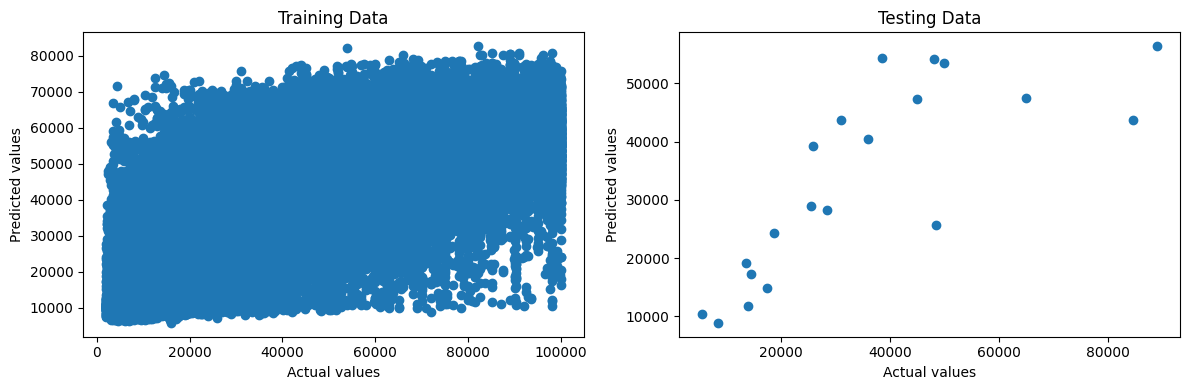

,train,test
r_sq,6.147774e-01,5.913420e-01
mse,1.798454e+08,2.179296e+08
rmse,1.341064e+04,1.476244e+04


In [51]:
xgb_model,xgb_result = model_performance(XGBRegressor(n_estimators= 763,
                                                        max_depth = 3,
                                                        learning_rate = 0.04236490789285951,
                                                        min_child_weight = 3,
                                                        objective='reg:squarederror'),
                                        X_train,X_test,y_train,y_test)
xgb_result

In [59]:
holdout_data = encoded_data[encoded_data['train_test_flag'] == 'test']
print(holdout_data.shape)
holdout_data.head()

(125690, 3605)


,model_year,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Bugatti,brand_Buick,brand_Cadillac,brand_Chevrolet,...,int_col_Walnut,int_col_Whisper Beige,int_col_White,int_col_White / Brown,int_col_Yellow,int_col_–,accident_None reported,milage,train_test_flag,price
0,2015,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,98000,test,NaN
1,2020,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,9142,test,NaN
2,2022,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,28121,test,NaN
3,2016,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,61258,test,NaN
4,2018,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,59000,test,NaN


In [61]:
holdout_data = holdout_data.drop(['train_test_flag','price'],axis=1)

In [65]:
submission_data = pd.DataFrame()
submission_data['id'] = data[data['train_test_flag'] == 'test']['id']

In [67]:
submission_data['price'] = xgb_model.predict(holdout_data)

In [69]:
submission_data.to_csv('submission_data2.csv',index=False)